In [1]:
import nglview as nv
import glob
import mdtraj as md
import os

In [2]:
trj_dir = 'PentaPeptideBackBoneSweepFinal/gen=256_dis=512_latent=128_genNet=simple_disNet=simple_opt=rmsprop/trjs/trj*xyz'

In [3]:
trj_fnames = glob.glob(trj_dir)
trj_fnames.sort(key=os.path.getmtime)
len(trj_fnames)

279

In [4]:
full_trj = md.load('data_mdshare/pentapeptide-impl-solv.pdb')
full_trj

<mdtraj.Trajectory with 1 frames, 94 atoms, 5 residues, and unitcells at 0x7fc62ab24eb8>

In [5]:
cond_trj = full_trj.atom_slice(full_trj.top.select('backbone'))

In [6]:
trj = md.load(trj_fnames[-1], top=cond_trj.top)
trj

<mdtraj.Trajectory with 25005 frames, 20 atoms, 5 residues, without unitcells at 0x7fc62ab15f60>

In [7]:
v = nv.show_mdtraj(trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=25004)

In [8]:
from GAN_datamodule import PentaPeptideBackbone

In [9]:
data = PentaPeptideBackbone()

Using 20 trajectories for training consisting of 100020 frames
Using 5 trajectories for evaluation consisting of 25005 frames
Generating 4-dim TICA embedding as the conditioning


calculate covariances:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
# compare reconstructed traj against conditioning
from nglview import NGLWidget
view = NGLWidget()
view.add_trajectory(data.val_cond_trj)
view.add_trajectory(trj)
op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=25004)

In [12]:
import pickle as pkl
import numpy as np
from copy import deepcopy

In [13]:
ddpm = pkl.load(open('/project/andrewferguson/Mike/geometric_deep_learning/DDPM/test_trajs/pep-bb.pkl','rb'))

In [14]:
data.val_cond_trj

<mdtraj.Trajectory with 25005 frames, 20 atoms, 5 residues, and unitcells at 0x7fc548e134a8>

In [15]:
ddpm.center_coordinates()

<mdtraj.Trajectory with 25005 frames, 20 atoms, 5 residues, without unitcells at 0x7fc5483956d8>

In [16]:
trj.center_coordinates()

<mdtraj.Trajectory with 25005 frames, 20 atoms, 5 residues, without unitcells at 0x7fc62ab15f60>

In [17]:
val_trj = deepcopy(data.val_cond_trj.center_coordinates())

In [18]:
combined_top = val_trj.top.join(trj.top).join(ddpm.top)
combined_top

<mdtraj.Topology with 3 chains, 15 residues, 60 atoms, 57 bonds at 0x7fc5483fa668>

In [39]:
gan_xyz = trj.xyz + np.array([[0, 1.25, 0]])
ddpm_xyz = ddpm.xyz + np.array([[0, 2.5, 0]])

In [40]:
combined_xyz = np.concatenate((val_trj.xyz, gan_xyz, ddpm_xyz), 1)
combined_xyz.shape

(25005, 60, 3)

In [41]:
combined_trj = md.Trajectory(combined_xyz, topology=combined_top)

In [42]:
v = nv.show_mdtraj(combined_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=25004)

In [11]:
import numpy as np
from scipy.spatial.distance import pdist

In [12]:
pdists_real = np.concatenate([pdist(xyz)[None] for xyz in data.val_cond_trj.xyz])
pdists_fake = np.concatenate([pdist(xyz)[None] for xyz in trj.xyz])

In [13]:
TICS_real = data.tica_estimator.transform(pdists_real)
TICS_fake = data.tica_estimator.transform(pdists_fake)

In [14]:
import pyemma as py
import matplotlib.pyplot as plt

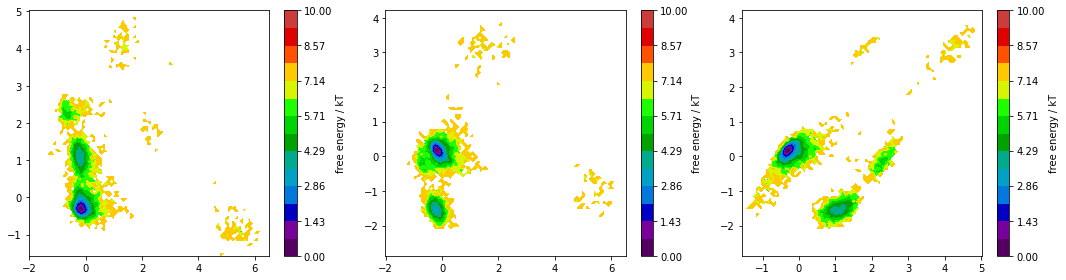

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(TICS_real[:,0], TICS_real[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(TICS_real[:,0], TICS_real[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(TICS_real[:,1], TICS_real[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

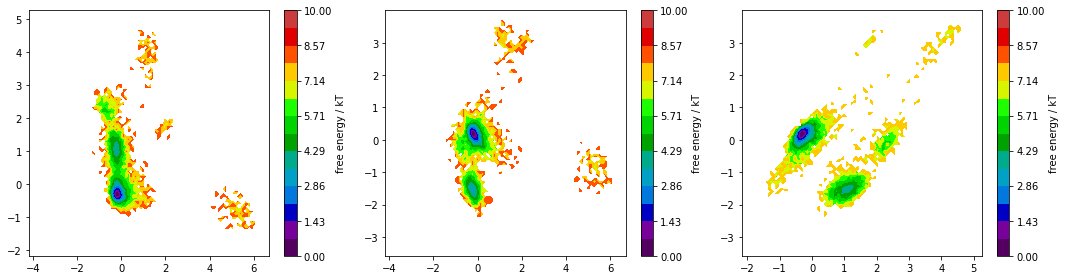

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(TICS_fake[:,0], TICS_fake[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(TICS_fake[:,0], TICS_fake[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(TICS_fake[:,1], TICS_fake[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

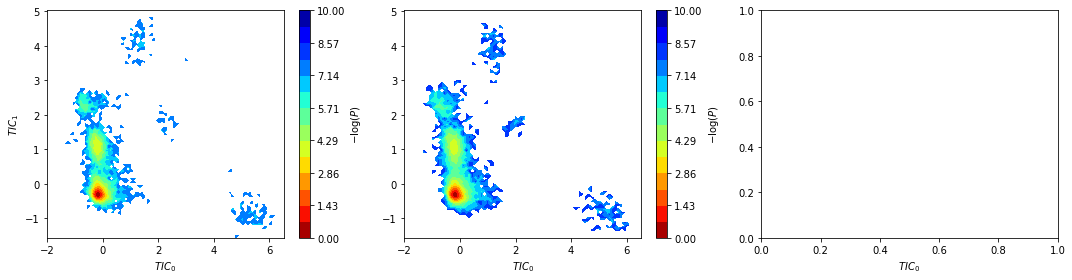

In [38]:

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(TICS_real[:, 0], TICS_real[:, 1], levels=np.linspace(0, 10, 15),
                          bins=25, ax=ax[0], cbar_label=r'$-\log(P)$', cmap='jet_r')
py.plots.plot_free_energy(TICS_fake[:, 0], TICS_fake[:, 1],  levels=np.linspace(0, 10, 15),
                          bins=25, ax=ax[1], cbar_label=r'$-\log(P)$', cmap='jet_r')
x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()
ax[1].set_xlim(*x_lim)
ax[1].set_ylim(*y_lim)
ax[0].set_ylabel(r'$TIC_1$')
for a in ax:
    a.set_xlabel(r'$TIC_0$')
plt.tight_layout()

In [17]:
from scipy.stats import pearsonr

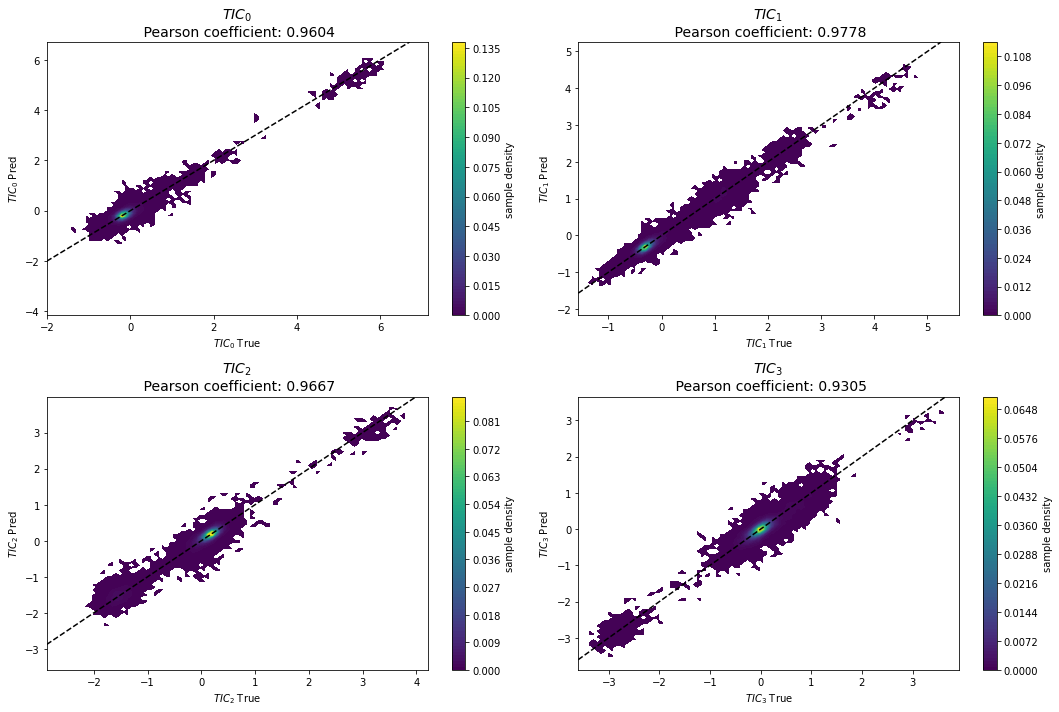

In [19]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))
corrs = list()
for tic_idx, ax in enumerate(axes.flatten()):
    py.plots.plot_density(TICS_real[:, tic_idx], TICS_fake[:, tic_idx], ax=ax)
    p_phi, _ = pearsonr(TICS_real[:, tic_idx], TICS_fake[:, tic_idx])
    corrs.append(p_phi)
    ax.set_title(f'$TIC_{tic_idx}$ \n Pearson coefficient: {p_phi:.4g}', fontsize=14)
    ax.set_xlabel(f'$TIC_{tic_idx}$ True')
    ax.set_ylabel(f'$TIC_{tic_idx}$ Pred')
    y_min,y_max = ax.get_ylim()
    x_min,x_max = ax.get_xlim()
    ax.plot([x_min, y_max], [x_min,y_max], c='k', linestyle='--')
plt.tight_layout()

In [20]:
np.mean(corrs)

0.9588626247338252

In [21]:
def empirical_correlation(x, y):
    xc = x - np.mean(x, axis=0)
    yc = y - np.mean(y, axis=0)
    corr = np.mean(xc*yc, axis=0)/(np.std(x, axis=0)*np.std(y, axis=0))
    return corr


def generate_its(data, lags):
    its = []
    for lag in lags: 
        if type(data) is list:
            x0 = np.concatenate([item[:-lag] for item in data])
            x1 = np.concatenate([item[lag:] for item in data])
        else:
            x0 = data[:-lag]
            x1 = data[lag:]
        ts = empirical_correlation(x0, x1)
        its.append(-lag/np.log(np.abs(ts)))
    
    return np.array(its)

In [35]:
lags = [1,5,10,15,20,25,30,35,40]

In [36]:
real_its = generate_its([x for x in TICS_real.reshape(5, -1, 4)], lags)
fake_its = generate_its([x for x in TICS_fake.reshape(5, -1, 4)], lags)

Text(0.5, 0, 'Lag time')

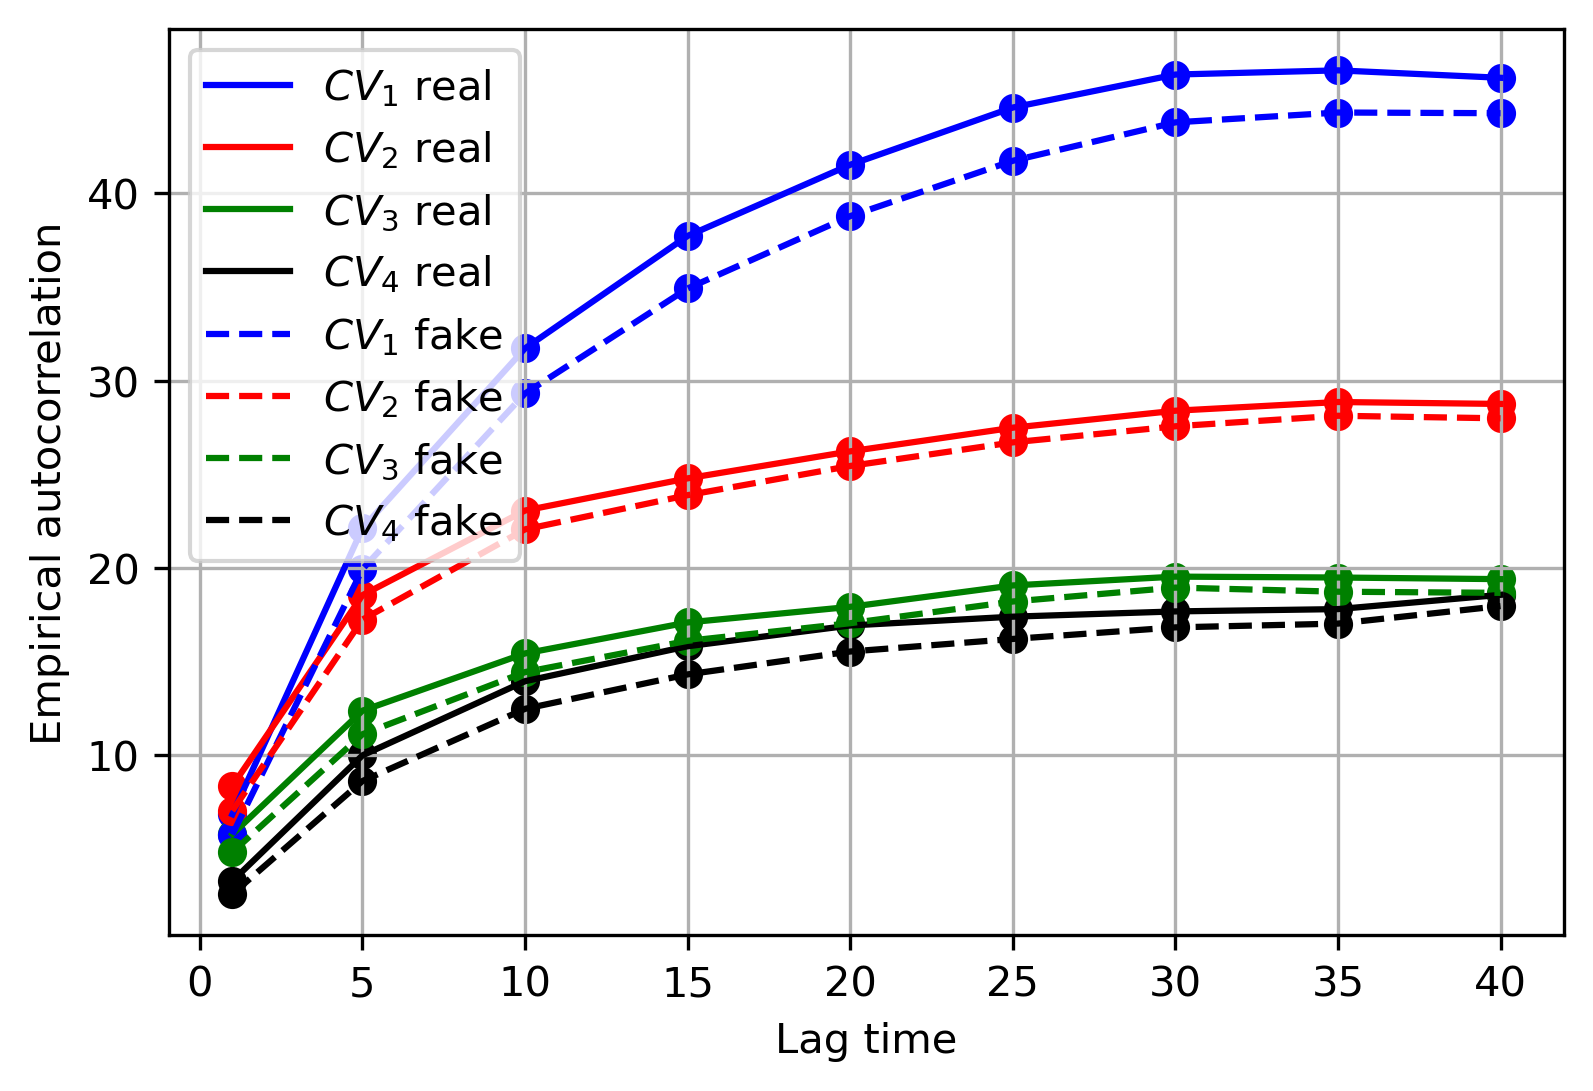

In [37]:
plt.figure(dpi=300)
colors = ['b','r', 'g', 'k']
for i in range(real_its.shape[1]):
    plt.plot(lags,real_its[:, i], label=f'$CV_{i+1}$ real', c=colors[i])
    plt.scatter(lags,real_its[:, i], c=colors[i])

for i in range(fake_its.shape[1]):
    plt.plot(lags,fake_its[:, i], label=f'$CV_{i+1}$ fake', linestyle='--', c=colors[i])
    plt.scatter(lags,fake_its[:, i], c=colors[i])

plt.legend()
plt.grid()
plt.ylabel('Empirical autocorrelation')
plt.xlabel('Lag time')

In [22]:
trj_ref = data.val_cond_trj
all_bonds = [(b[0].index, b[1].index) for b in trj.top.bonds]
bond_dists_r = md.compute_distances(trj_ref, all_bonds)
bond_dists_s = md.compute_distances(trj, all_bonds)
bond_rmsd = np.sqrt(np.mean((bond_dists_s - bond_dists_r) ** 2))
bond_rmsd

0.007691143

In [23]:
min_r, max_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
correct_aa = np.sum((bond_dists_s < max_r) & (bond_dists_s > min_r), axis=1)
auc_aa = []
for i in range(len(all_bonds)):
    auc = np.mean(correct_aa > i)
    auc_aa.append(auc)
print(np.sum(auc_aa) / len(all_bonds))

0.9356044580557571


In [40]:
from tqdm.autonotebook import tqdm

In [41]:
frames = list()
for t in tqdm(trj_fnames):
    frame = md.load(t, top=trj.top)[0]
    frames.append(frame)

  0%|          | 0/279 [00:00<?, ?it/s]

In [42]:
frames_trj = md.join(frames).center_coordinates()

In [43]:
frames_trj.save_pdb('frame_pentapeptide_backbone_trj.pdb')

In [44]:
md.load('data_mdshare/pentapeptide-impl-solv.pdb').atom_slice(full_trj.top.select('backbone')).center_coordinates().save_pdb('pentapeptide_backbone_pdb_center.pdb')